### Library Installation

In the following cell, we are installing several Python libraries necessary for our analysis:

- `pandas` for data manipulation and analysis.
- `nltk` for natural language processing tasks.
- `wordcloud` for generating word cloud visualizations.
- `matplotlib` for plotting and visualizations.
- `sklearn` for machine learning and data modeling.
- `praw` for interacting with the Reddit API.

**Note**: Some libraries like `random`, `warnings`, `json`, and `re` are part of Python's standard library and do not require installation.



In [4]:
# Install the required libraries (uncomment to install)

# !pip install praw
# !pip install pandas
# !pip install nltk
# !pip install wordcloud
# !pip install matplotlib
# !pip install sklearn

In [5]:
# Data Handling
import pandas as pd
import json
import csv
import re
from datetime import datetime

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Configuration and Randomization
import random
import warnings
warnings.filterwarnings('ignore')

# Additional Libraries
import praw

# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mariy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mariy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mariy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

https://www.reddit.com/r/Dublin/comments/12pqv76/how_are_dublin_bikes_these_days/ - post from where comments will be extracted.

A specific post was chosen called 'How are dublin bikes these days'. The focus is on a specific post in order to ensure that the data collected is highly relevant to the topic. In this case, opinions, experiences, and discussions specifically about Dublin bikes are gathered, leading to a more focused dataset. 

Due to security reason and best practices in software development, the credentials used to pull the data from Reddit are saved in a separate json file and will be imported in the jupyter notebook using the open() method. This opens the file in read mode ('r'). The with statement is used to ensure that the file is properly closed.

https://docs.python.org/3/library/functions.html#open

In order to know the structure of the configuration file, a sample file with dummy data will be uploaded in the git repository named 'example_credentials_reddit.json'.

In [6]:
config_file_path = 'reddit_credentials.json'

with open(config_file_path, 'r') as file:
    config = json.load(file)

client_id = config['REDDIT_CLIENT_ID']
client_secret = config['REDDIT_CLIENT_SECRET']
user_agent = 'mariyabkol'

A Python Reddit API Wrapper is initialized, which is a Python library for interacting with the Reddit API - https://praw.readthedocs.io/en/stable/getting_started/configuration.html

As mnetioned above since comments from a specific post will be pulled, the post id is defined in the submission_id variable. A csv_file path will be set and the headers will be defined. Each comment will have the following properties: 
- the comment text itself
- the timestamp it was created
- the title of the reddit post
- the id of the submission

The open with command will be used again, however this time it will be in write mode 'w', in order to write in the csv file. 

In [7]:
# Initialize PRAW
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

submission_id = '12pqv76'

csv_file_path = 'reddit_bike_comments.csv'
fieldnames = ['comment', 'created_utc', 'submission_title', 'submission_id']


with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    submission = reddit.submission(id=submission_id)
    submission.comments.replace_more(limit=None)

    for comment in submission.comments.list():
        writer.writerow({
            'comment': comment.body,
            'created_utc': datetime.fromtimestamp(comment.created_utc),
            'submission_title': submission.title,
            'submission_id': submission.id,
        })

print("Data collection complete. Check the CSV file called 'reddit_bike_comments'.")

Data collection complete. Check the CSV file called 'reddit_bike_comments'.


In [8]:
comments_bike_df = pd.read_csv('reddit_bike_comments.csv')

In [9]:
comments_bike_df.head()

,comment,created_utc,submission_title,submission_id
0,Never used them but also had no idea it was 35...,2023-04-17 19:58:56,How are Dublin Bikes these days?,12pqv76
1,Still good. The app is now way better and you ...,2023-04-17 19:12:29,How are Dublin Bikes these days?,12pqv76
2,I think the €35 is a steal. There are times in...,2023-04-17 20:10:08,How are Dublin Bikes these days?,12pqv76
3,Been using them for 9 months and I love em. Ob...,2023-04-17 19:38:49,How are Dublin Bikes these days?,12pqv76
4,I lived in town when they first came out and i...,2023-04-17 20:39:22,How are Dublin Bikes these days?,12pqv76


In [10]:
comments_bike_df.shape

(31, 4)

A function for preprocessing the comments will be created and later on applied in order to prepare and clean the data for the sentiment analysis.

The following steps are performed: 

Removing URLs: Uses a regular expression to remove any URLs. 
     URLs in comments are usually not relevant to text analysis and can be considered noise and they will be removed.

Removing Special Characters and Numbers: Again uses a regex to keep only alphabetic characters.
    As the analysis is focused on linguistic content, special characters and numbers will not be neccessary. 

Lowercasing: Converts the text to lowercase to ensure uniformity.
    As most text analysis techniques are case-sensitive, and for consistency, everything will be converted to lowercase.
    
Tokenizing: Splits the comment into individual words (tokens).
     Preparing the data for further processing like counting word frequency, sentiment analysis, etc.
     
Removing Stopwords: Filters out common words that are typically uninformative.
    Stopwords are common words like 'the', 'is', 'in', which usually don't contribute to the overall meaning of the text as they do not bring any sentiment. 
    
Character Count: Calculates the total number of characters in the comment (excluding spaces).
    Provides a basic quantitative measure of the comment's length.
    
Average Word Length: Computes the average length of the words in the comment.
    A metric that can give insights into the complexity or readability of the text.
    
Hashtag Count: Counts the number of words that start with a hashtag (#), assuming these are hashtags.
    Hashtags are often used to mark keywords or topics in social media texts - this can help in identifying the main topics or trends in the comments. 
    
A zip function (zip(*...)) is applied in order to unpack into four columns in the DataFrame: char_count, avg_word_lenght, hashtag_count and cleaned comment.

In [11]:
def preprocess_comments(comment):
    # Removing URLs
    comment = re.sub(r'http\S+', '', comment)
    # Removing special characters and numbers
    comment = re.sub(r'[^A-Za-z\s]', '', comment)
    # Lowercasing
    comment = comment.lower()
    # Tokenizing
    words = word_tokenize(comment)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Calculating the number of characters (without spaces)
    char_count = sum(len(word) for word in words)
    # Calculating the average word length
    avg_word_length = char_count / len(words) if words else 0
    # Counting hashtags (assuming words starting with '#' are hashtags)
    hashtag_count = sum(1 for word in words if word.startswith('#'))
    return char_count, avg_word_length, hashtag_count, ' '.join(words)

# Applying the preprocessing function
comments_bike_df['char_count'], comments_bike_df['avg_word_length'], comments_bike_df['hashtag_count'], comments_bike_df['cleaned_comment'] = zip(*comments_bike_df['comment'].apply(preprocess_comments))

comments_bike_df.head()


,comment,created_utc,submission_title,submission_id,char_count,avg_word_length,hashtag_count,cleaned_comment
0,Never used them but also had no idea it was 35...,2023-04-17 19:58:56,How are Dublin Bikes these days?,12pqv76,55,5.000000,0,never used also idea year thats really good pr...
1,Still good. The app is now way better and you ...,2023-04-17 19:12:29,How are Dublin Bikes these days?,12pqv76,74,4.625000,0,still good app way better unlock phone station...
2,I think the €35 is a steal. There are times in...,2023-04-17 20:10:08,How are Dublin Bikes these days?,12pqv76,119,4.407407,0,think steal times dublin city would get taxi b...
3,Been using them for 9 months and I love em. Ob...,2023-04-17 19:38:49,How are Dublin Bikes these days?,12pqv76,128,5.333333,0,using months love em obviously sometimes stati...
4,I lived in town when they first came out and i...,2023-04-17 20:39:22,How are Dublin Bikes these days?,12pqv76,126,5.250000,0,lived town first came year jumped years well w...


In [12]:
sent_analyzer = SentimentIntensityAnalyzer()

# Example
sentence = "fantastic price even electric ones"
print(sent_analyzer.polarity_scores(sentence))

{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.5574}


In [13]:
def get_sentiment_scores(comment):
    return sent_analyzer.polarity_scores(comment)

comments_bike_df['sentiment_scores'] = comments_bike_df['cleaned_comment'].apply(get_sentiment_scores)

comments_bike_df.head()

,comment,created_utc,submission_title,submission_id,char_count,avg_word_length,hashtag_count,cleaned_comment,sentiment_scores
0,Never used them but also had no idea it was 35...,2023-04-17 19:58:56,How are Dublin Bikes these days?,12pqv76,55,5.000000,0,never used also idea year thats really good pr...,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp..."
1,Still good. The app is now way better and you ...,2023-04-17 19:12:29,How are Dublin Bikes these days?,12pqv76,74,4.625000,0,still good app way better unlock phone station...,"{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp..."
2,I think the €35 is a steal. There are times in...,2023-04-17 20:10:08,How are Dublin Bikes these days?,12pqv76,119,4.407407,0,think steal times dublin city would get taxi b...,"{'neg': 0.165, 'neu': 0.732, 'pos': 0.104, 'co..."
3,Been using them for 9 months and I love em. Ob...,2023-04-17 19:38:49,How are Dublin Bikes these days?,12pqv76,128,5.333333,0,using months love em obviously sometimes stati...,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp..."
4,I lived in town when they first came out and i...,2023-04-17 20:39:22,How are Dublin Bikes these days?,12pqv76,126,5.250000,0,lived town first came year jumped years well w...,"{'neg': 0.113, 'neu': 0.745, 'pos': 0.142, 'co..."


A threshold of 0.05 for categorizing sentiments as positive, negative, or neutral, especially is chosen, as this is a standard guideline. This threshold is based on empirical choices made during the development and validation of the tool.

https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399

In [14]:
def format_output(output_dict):
    polarity = "neutral"
    if(output_dict['compound'] >= 0.05):
        polarity = "positive"
    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"
    return polarity

def predict_sentiment(text):
    output_dict =  sent_analyzer.polarity_scores(text)
    return format_output(output_dict)

comments_bike_df['sentiment'] = comments_bike_df['cleaned_comment'].apply(predict_sentiment)

comments_bike_df.to_csv('sentiment_analysis_bike.csv', index=False)

print("Sentiment analysis completed and saved to sentiment_analysis_bike.csv")

Sentiment analysis completed and saved to sentiment_analysis_bike.csv


In [15]:
analysis_df = pd.read_csv("sentiment_analysis_bike.csv")

In [16]:
analysis_df.head()

,comment,created_utc,submission_title,submission_id,char_count,avg_word_length,hashtag_count,cleaned_comment,sentiment_scores,sentiment
0,Never used them but also had no idea it was 35...,2023-04-17 19:58:56,How are Dublin Bikes these days?,12pqv76,55,5.000000,0,never used also idea year thats really good pr...,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...",positive
1,Still good. The app is now way better and you ...,2023-04-17 19:12:29,How are Dublin Bikes these days?,12pqv76,74,4.625000,0,still good app way better unlock phone station...,"{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...",positive
2,I think the €35 is a steal. There are times in...,2023-04-17 20:10:08,How are Dublin Bikes these days?,12pqv76,119,4.407407,0,think steal times dublin city would get taxi b...,"{'neg': 0.165, 'neu': 0.732, 'pos': 0.104, 'co...",negative
3,Been using them for 9 months and I love em. Ob...,2023-04-17 19:38:49,How are Dublin Bikes these days?,12pqv76,128,5.333333,0,using months love em obviously sometimes stati...,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...",positive
4,I lived in town when they first came out and i...,2023-04-17 20:39:22,How are Dublin Bikes these days?,12pqv76,126,5.250000,0,lived town first came year jumped years well w...,"{'neg': 0.113, 'neu': 0.745, 'pos': 0.142, 'co...",negative


In [17]:
sentiment_counts = analysis_df['sentiment'].value_counts()

print("Sentiment Counts:")
print(sentiment_counts)

Sentiment Counts:
positive    18
negative     8
neutral      5
Name: sentiment, dtype: int64


A visualization displaying a word cloud from a collecation of text comments (all comments within the dataset) is created, visualizing the frequency of word occurrences - more frequent words will appear larger. 


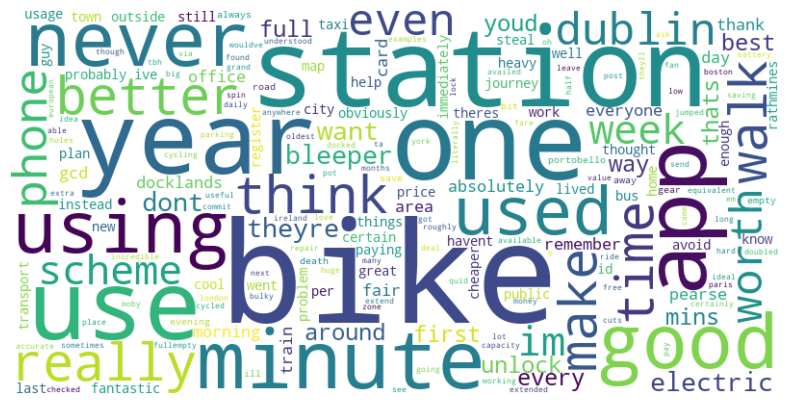

In [18]:
text_corpus = " ".join(comment for comment in comments_bike_df.cleaned_comment)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

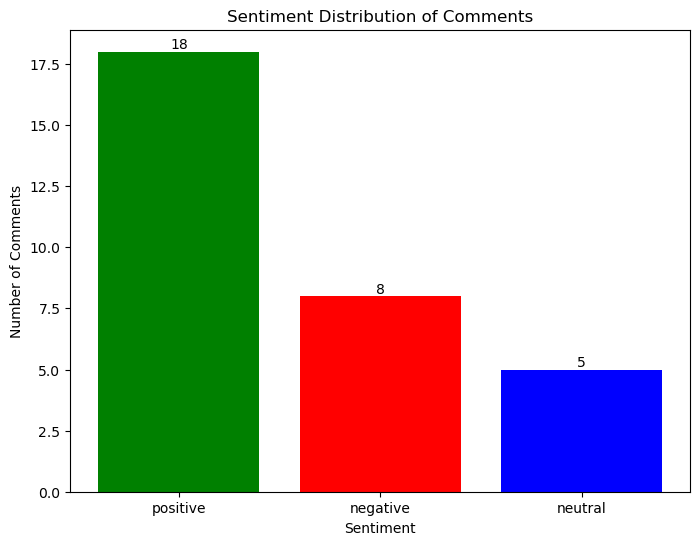

In [19]:
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'blue'])

plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.title('Sentiment Distribution of Comments')
plt.xticks(list(sentiment_counts.index))

for i, count in enumerate(sentiment_counts):
    plt.text(i, count, str(count), ha = 'center', va = 'bottom')

plt.show()

The analysis suggests that the sentiment in the dataset is predominantly positive, with a lesser but notable amount of negative sentiment, and a smaller proportion of neutral sentiment.

## **Bag of Words Vectorization-Based Models**

https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/

In [20]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(analysis_df['comment'])

text_counts

<31x349 sparse matrix of type '<class 'numpy.int64'>'
	with 555 stored elements in Compressed Sparse Row format>

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, analysis_df['sentiment'], test_size=0.25, random_state=5)

In [22]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((23, 349), (8, 349), (23,), (8,))

In [23]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracuy Score: ",accuracy_score)

Accuracuy Score:  0.625


Accuracy of 62% is a good starting point, considering the size of the data. 